In [7]:
# This script separates out the columns of data that have the author genders
# and names, as well as the columns for years and author counts.  
# It then runs a chi squared test on the proportions of male and female 
# authors who are first auth vs second vs third vs last.

# Here's a link to an explanation of how to do chi-squared test in Python:
# http://connor-johnson.com/2014/12/31/the-pearson-chi-squared-test-with-python-and-r/

#                      ****PREPARE EVERYTHING!****

import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt
%matplotlib inline

# Read in just the columns from the csv file that you'll need:
path_name = "/Users/ilya/Projects/abstracts_project/data files/"
file_name = "all_data_merged_restructured.csv"

dat = pd.read_csv(path_name+file_name, usecols = ['first_auth_gender', 'second_auth_gender', 'third_auth_gender', 'last_auth_gender', 'year', 'auth_count'])

print dat.head()

# Define function to calculate chi square results given data in the format that
# will be produced below.
def chi_sq(year, df, gender_info = 'female'):
    """Takes a year and a dataframe that has two columns representing male
    authorships followed by 2 columns representing female authorships, and
    returns a tuple that's the chisquare value followed by the p value. """
    a = df.loc[year]
#     print a
    male = a[[1,2]]
    female = a[[3,4]]
#     print female
    if gender_info == 'male':
#         print scipy.stats.chisquare( male )
        return scipy.stats.chisquare( male )
    elif gender_info == 'female':
#         print scipy.stats.chisquare( female )
        return scipy.stats.chisquare( female )

   year  auth_count first_auth_gender second_auth_gender third_auth_gender  \
0  2013           3            female             female            female   
1  2012           1              male            unknown         untouched   
2  2011           2            female               male         untouched   
3  2009           1              male            unknown         untouched   
4  2014           2            female             female         untouched   

  last_auth_gender  
0        untouched  
1        untouched  
2        untouched  
3        untouched  
4        untouched  


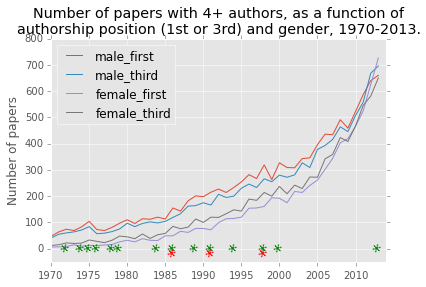

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     155.4
Date:                Wed, 15 Jul 2015   Prob (F-statistic):           1.06e-15
Time:                        15:34:41   Log-Likelihood:                 44.373
No. Observations:                  44   AIC:                            -84.75
Df Residuals:                      42   BIC:                            -81.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -25.8620      2.136    -12.108      0.0

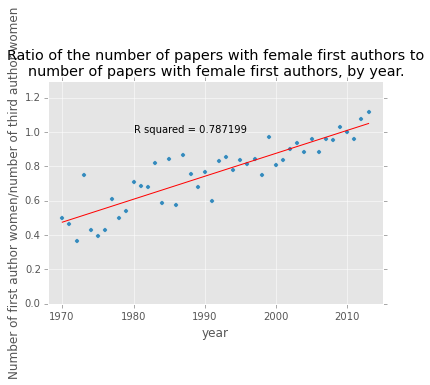

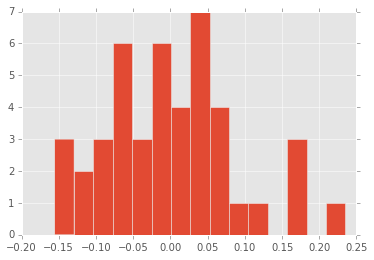

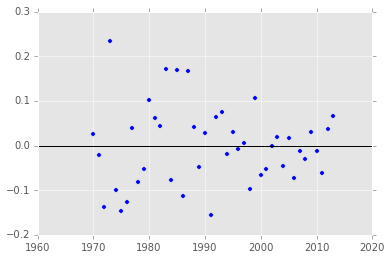

(8.1272859452007271, 0.0043603971118019412, 9.5154776741171361, 0.0035962969511193843)


In [8]:


#         *****************************************************
#                  ***Get started on the real goals!***

# Plot the number of papers with male and female first and third authors. Run a
# chi squared test on the within-sex difference and include results in plot.

# Get just the data for papers with at least 4 authors:
four_plus_auth = dat[dat.auth_count > 3][['year','first_auth_gender',
                                     'third_auth_gender']]

# Drop rows that have a male/female id in both columns:
drop_rows_with = ['unknown', 'mostly_female', 'mostly_male']
for x in drop_rows_with:
    four_plus_auth = four_plus_auth[four_plus_auth.first_auth_gender != x]
    four_plus_auth = four_plus_auth[four_plus_auth.third_auth_gender != x]

# Get counts of male/female first/third for each year:
years = range(1970,2015)
counts_four_plus = pd.DataFrame(columns = ['year', 'male_first', 'male_third', 'female_first', 'female_third'])
for y in years:
    temp = four_plus_auth[four_plus_auth.year == y]
    male_first = (temp.first_auth_gender == 'male').sum()
    male_third = (temp.third_auth_gender == 'male').sum()
    female_first = (temp.first_auth_gender == 'female').sum()
    female_third = (temp.third_auth_gender == 'female').sum()
    counts_four_plus.loc[y] = [y, male_first, male_third, female_first, female_third]

plt.style.use('ggplot')

to_plot = counts_four_plus.iloc[:-1,1:]
to_plot.plot(kind = 'line')
plt.title('Number of papers with 4+ authors, as a function of\nauthorship position (1st or 3rd) and gender, 1970-2013.')
plt.axis([1970, 2014, -50,800])
plt.ylabel('Number of papers')
for y in years[:-1]:
#     print y
    # if chi_sq(y, counts_four_plus)[1] < .01:
    #     plt.annotate('**', xy = (y, -20), rotation = 45, color = 'green', fontsize = 18)
    if chi_sq(y, counts_four_plus)[1] < .05:
        plt.annotate('*', xy = (y-1, -25), rotation = 45, color = 'green', fontsize = 18)
    # else:
    #     plt.annotate('o', xy = (y, -20))
    # if chi_sq(y, counts_four_plus, gender_info = 'male')[1] < .01:
    #     plt.annotate('**', xy = (y, -40), rotation = 45, color = 'red', fontsize = 18)
    if chi_sq(y, counts_four_plus, gender_info = 'male')[1] < .05:
        plt.annotate('*', xy = (y-1, -45), rotation = 45, color = 'red', fontsize = 18)
    # else:
    #     plt.annotate('o', xy = (y, -40))

plt.show()

#  Plot the ratio of the count of papers with a female first author and a female 
# third author, by year. Regress ratio on year to find out how strong the effect is.

to_plot = counts_four_plus.iloc[:-1, 3:]
to_plot['year'] = to_plot.index
to_plot['ratio'] = to_plot.female_first / to_plot.female_third
to_plot.plot(kind = 'scatter', x = 'year', y = 'ratio')
plt.title('Ratio of the number of papers with female first authors to\nnumber of papers with female first authors, by year.')
plt.ylabel('Number of first author women/number of third author women')
plt.axis([1968, 2015,0,1.3])

# DONT PLOT YET! First, run the linear regression to find out whether or not the
# ratio has changed over time.
import statsmodels.formula.api as smf

lm = smf.ols(formula='ratio ~ year', data=to_plot).fit()
print lm.summary()

# Add regression line to plot:
X_new = pd.DataFrame({'year': [to_plot.year.min(), to_plot.year.max()]})
preds = lm.predict(X_new)
plt.plot(X_new, preds, c = 'red')
plt.annotate('R squared = %2f' % lm.rsquared, xy = (1980, 1))
plt.show()

# Hist of model residuals:
resids1 = lm.resid
plt.hist(resids1.values, bins = 15)
plt.show()

# Residual plot against values of predictor:
plt.scatter(x = resids1.index, y = resids1.values)
plt.axhline(y = 0, color = 'black')
plt.show()

# Do a Breusch-Pagan for heteroskedasticity:
from statsmodels.stats.diagnostic import het_breushpagan
from statsmodels.tools.tools import add_constant
yrs = add_constant(resids1.index)
print het_breushpagan(resid = resids1, exog_het = yrs)
# The error variance depends on the year!!! Ok, now what?


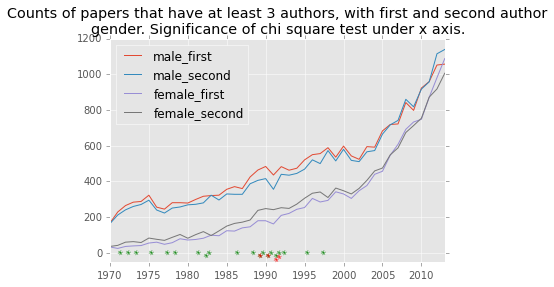

In [9]:
#           THE MOST SENSICAL ANALYSIS HERE:

# This analysis looks at counts of first and second authors who are men and who
# are women, for papers with at least 3 authors. I call this "obscure authorship"
# because the first authorship is a coveted spot, the last authorship is often
# taken by the overseeing professor on the project, and the second authorship
# is more obscure than the first.

# Get just the data for papers with at least 3 authors:
three_plus_auth = dat[dat.auth_count > 2][['year','first_auth_gender',
                                     'second_auth_gender']]

# Drop rows that have a male/female id in both columns:
drop_rows_with = ['unknown', 'mostly_female', 'mostly_male']
for x in drop_rows_with:
    three_plus_auth = three_plus_auth[three_plus_auth.first_auth_gender != x]
    three_plus_auth = three_plus_auth[three_plus_auth.second_auth_gender != x]

# Get counts of male/female first/third for each year:
years = range(1970,2015)
counts_three_plus = pd.DataFrame(columns = ['year', 'male_first', 'male_second', 'female_first', 'female_second'])
for y in years:
    temp = three_plus_auth[three_plus_auth.year == y]
    male_first = (temp.first_auth_gender == 'male').sum()
    male_second = (temp.second_auth_gender == 'male').sum()
    female_first = (temp.first_auth_gender == 'female').sum()
    female_second = (temp.second_auth_gender == 'female').sum()
    counts_three_plus.loc[y] = [y, male_first, male_second, female_first, female_second]

plt.style.use('ggplot')

to_plot = counts_three_plus.iloc[:-1,1:]
to_plot.plot(kind = 'line')
plt.title('Counts of papers that have at least 3 authors, with first and second author\ngender. Significance of chi square test under x axis.')
plt.axis([1970, 2013, -50,1200])
for y in years[:-1]:
#     print y
    if chi_sq(y, counts_three_plus)[1] < .01:
        plt.annotate('**', xy = (y, -20), rotation = 45, color = 'green')
    elif chi_sq(y, counts_three_plus)[1] < .05:
        plt.annotate('*', xy = (y, -20), rotation = 45, color = 'green')
    # else:
    #     plt.annotate('o', xy = (y, -20))
    if chi_sq(y, counts_three_plus, gender_info = 'male')[1] < .01:
        plt.annotate('**', xy = (y, -40), rotation = 45, color = 'red')
    elif chi_sq(y, counts_three_plus, gender_info = 'male')[1] < .05:
        plt.annotate('*', xy = (y, -40), rotation = 45, color = 'red')
    # else:
    #     plt.annotate('o', xy = (y, -40))

plt.show()

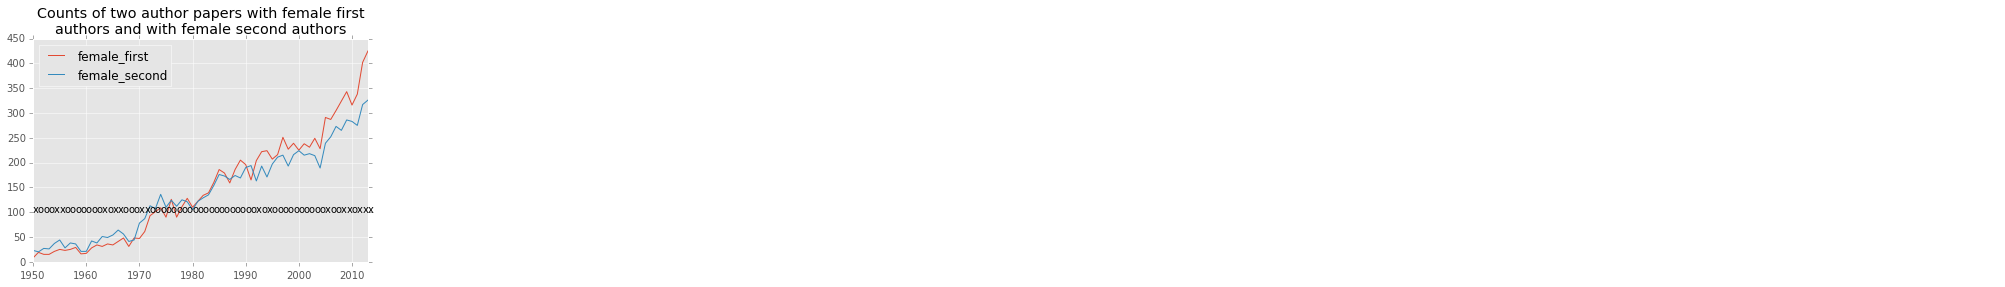

In [10]:
# Everything below is just extra, more fine-grained stuff.
#      ***Repeat the above analysis, but for 2-author papers only***

# Get just the data for papers with 2 authors:
two_auth = dat[dat.auth_count == 2][['year','first_auth_gender',
                                     'second_auth_gender']]

# Drop rows that have a male/female id in both columns:
drop_rows_with = ['unknown', 'mostly_female', 'mostly_male']
for x in drop_rows_with:
    two_auth = two_auth[two_auth.first_auth_gender != x]
    two_auth = two_auth[two_auth.second_auth_gender != x]

# Get counts of male/female first/second for each year:
years = range(1950,2015)
counts = pd.DataFrame(columns = ['year', 'male_first', 'male_second', 'female_first', 'female_second'])
for y in years:
    temp = two_auth[two_auth.year == y]
    male_first = (temp.first_auth_gender == 'male').sum()
    male_second = (temp.second_auth_gender == 'male').sum()
    female_first = (temp.first_auth_gender == 'female').sum()
    female_second = (temp.second_auth_gender == 'female').sum()
    counts.loc[y] = [y, male_first, male_second, female_first, female_second]

to_plot = counts.iloc[:-1,3:]
to_plot.plot(kind = 'line')
plt.title('Counts of two author papers with female first \nauthors and with female second authors')
for y in years:
    if chi_sq(y, counts)[1] < .05:
        plt.annotate('x', xy = (y, 100))
    else:
        plt.annotate('o', xy = (y, 100))

plt.show()

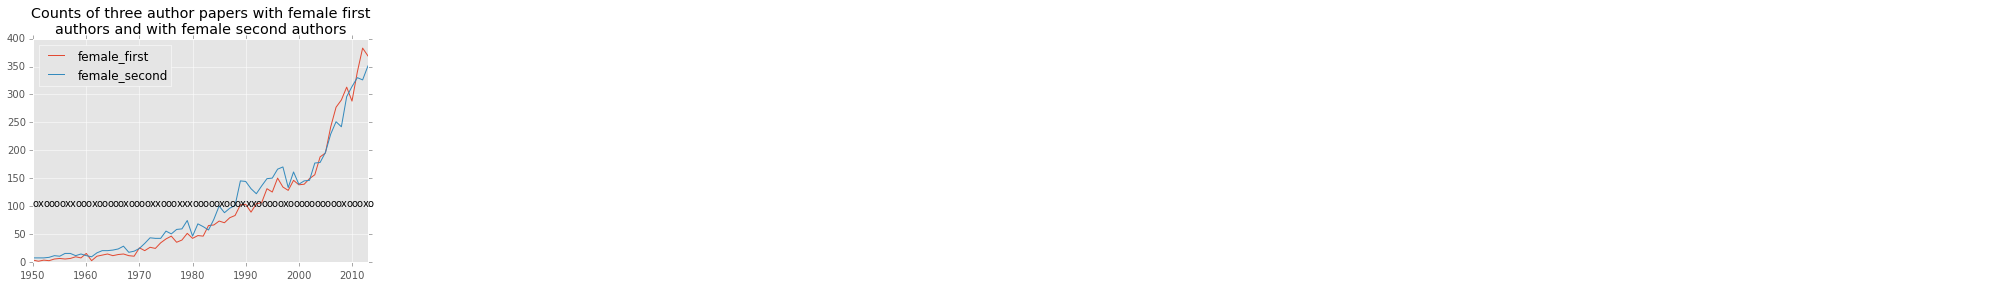

In [11]:



#             ***Now do it for 3-person papers only***
# So you're looking at papers with exactly 3 authors to see whether or not women
# are more likely to be in the first authorship spot than in the second one.

# Get just the data for papers with 3 authors:
three_auth = dat[dat.auth_count == 3][['year','first_auth_gender',
                                     'second_auth_gender']]

# Drop rows that have a male/female id in both columns:
drop_rows_with = ['unknown', 'mostly_female', 'mostly_male']
for x in drop_rows_with:
    three_auth = three_auth[three_auth.first_auth_gender != x]
    three_auth = three_auth[three_auth.second_auth_gender != x]

# Get counts of male/female first/second for each year:
years = range(1950,2015)
counts = pd.DataFrame(columns = ['year', 'male_first', 'male_second', 'female_first', 'female_second'])
for y in years:
    temp = three_auth[three_auth.year == y]
    male_first = (temp.first_auth_gender == 'male').sum()
    male_second = (temp.second_auth_gender == 'male').sum()
    female_first = (temp.first_auth_gender == 'female').sum()
    female_second = (temp.second_auth_gender == 'female').sum()
    counts.loc[y] = [y, male_first, male_second, female_first, female_second]

to_plot = counts.iloc[:-1,3:]
to_plot.plot(kind = 'line')
plt.title('Counts of three author papers with female first \nauthors and with female second authors')
for y in years:
    if chi_sq(y, counts)[1] < .05:
        plt.annotate('x', xy = (y, 100))
    else:
        plt.annotate('o', xy = (y, 100))

plt.show()